- v1: works till the categorical pipeline where it errors out for unknown variables
- v2: fully functional
- v3: baseline run (on the old dataset)
- v4: baseline run (on the full 2021.03.17_full_dataset)
- v5: baseline run (on 2021.03.19_full_dataset with all SSURGO variables)
- v6: aoc_roc (on 2021.03.19_full_dataset with all SSURGO variables). Mute the Stacking as it is not possible with RandomizedSearchCV. Have to have a dev split.
- v7: model v7 random state 123 on train/test, model v7.1 random_state 431 on train/dev/test
- v8g: Golden model

- ROC_AUC with lat, lon (baseline)
====================
lr:           0.64103
xgb:          0.82366
voting_clf:   0.83027
lgbm:         0.86395
stacking:     0.85923


- v9: without lat, lon

- ROC_AUC without lat, lon
=======================
lr:           0.64211
xgb:          0.8031
voting_clf:   0.83105
lgbm:         0.85952
stacking:     0.85427

- v9.1: without lat, lon, potential_wetland

- ROC_AUC without lat, lon, potential_wetland
===============
lr:           0.63992
xgb:          0.79093
voting_clf:   0.82987
lgbm:         0.85143
stacking:     0.84328

- v9.2: without lat, lon, potential_wetland, district

- ROC_AUC without lat, lon, potential_wetland, district
===============
lr:           0.64208
xgb:          0.77907
voting_clf:   0.79829
lgbm:         0.82675
stacking:     0.82185

- v9.3: without lat, lon, potential_wetland, district and flodfreqdc and drclassdcd as ordinal

- ROC_AUC on Test
===============
lr:           0.6382
xgb:          0.73089
voting_clf:   0.79126
lgbm:         0.82512
stacking:     0.8195

- v9.4: without lat, lon, potential_wetland, district, county 
- ROC_AUC on Test
===============
lr:           0.6395
xgb:          0.74096
voting_clf:   0.7911
lgbm:         0.82448
stacking:     0.82343

- v9.5: without lat, lon, potential_wetland, district, county, mukey
- ROC_AUC on Test
===============
lr:           0.65309
xgb:          0.75117
voting_clf:   0.77845
lgbm:         0.80626
stacking:     0.80424

- v9.5: without lat, lon, potential_wetland, district, county, mukey, and filtering out bad latitude
THIS IS SUSPECT. CANT REPEAT IT.
- ROC_AUC on Test
===============
lr:           0.63894
xgb:          0.74922
voting_clf:   0.79839
lgbm:         0.86986
stacking:     0.86281

- v9,5_r2: supposed to be repeat of v9.5 but unsuccessful (probably bcoz of wrong cat features)
- ROC_AUC on Test
===============
lr:           0.64148
xgb:          0.7066
lgbm:         0.79702
stacking:     0.78626
voting_clf:   0.7632

- ROC_AUC on Test
===============
lr:           0.62669
xgb:          0.71814
lgbm:         0.8006
stacking:     0.80005
voting_clf:   0.7683

- v9.6: baseline and filtering out bad latitude
- ROC_AUC on Test
===============
lr:           0.6306
xgb:          0.79659
voting_clf:   0.82816
lgbm:         0.85251
stacking:     0.84547

- v9.6_r2: baseline and filtering out bad latitude
- ROC_AUC on Test
===============
lr:           0.6302
xgb:          0.81153
voting_clf:   0.83019
lgbm:         0.85353
stacking:     0.85285


- ROC_AUC with lat, lon (baseline)
====================
lr:           0.64103
xgb:          0.82366
voting_clf:   0.83027
lgbm:         0.86395
stacking:     0.85923

- v9.4: without lat, lon, potential_wetland, district, county 
- ROC_AUC on Test
===============
lr:           0.6395
xgb:          0.74096
voting_clf:   0.7911
lgbm:         0.82448
stacking:     0.82343

- v10: baseline (with huc6, nearest wb/fl parameters added)

- ROC_AUC on Test
===============
lr:           0.64444
xgb:          0.80494
voting_clf:   0.82554
lgbm:         0.85336
stacking:     0.8514


# Constants and Imports


In [305]:
model_dict = {}
file_param_dict = {}
golden_models = ["v8g"]

# file params
stop_before_models = False
random_state = 123 # for train, dev, test splits
dev = True

INPUT_FILE_NAME = "2021.03.23_full_dataset"
FILE_VERSION = "v10"
run_models = False # BEWARE! This overwrites the models stored on disk
run_logistic = False

if FILE_VERSION in golden_models:
    if run_models:
        turn_off_run_models

        
file_param_dict["random_state"] = random_state
file_param_dict["dev"] = dev
file_param_dict["input_file_name"] = INPUT_FILE_NAME


In [306]:
# !pip install lightgbm
# !pip install xgboost
# !pip install mlxtend
# !pip install seaborn
# !pip install shapely
# !pip install geopandas

# import pickle

In [307]:
%matplotlib inline 

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import joblib
import pickle
from datetime import datetime

from sklearn import model_selection
from sklearn.svm import SVC
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# SK-learn libraries for machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from lightgbm import LGBMRegressor
from lightgbm import *
from xgboost import XGBRegressor
from xgboost import XGBRFClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import xgboost
import lightgbm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# SK-learn libraries for evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
pass

In [308]:
df_full = pd.read_pickle("../../../data/" + INPUT_FILE_NAME)
df_full.shape

(14619, 494)

In [309]:
# flod_ordered = ["None", "Very rare", "Rare", "Occasional", "Frequent", "Very frequent"]
# flod_dict = dict(zip(flod_ordered, range(len(flod_ordered))))

# def flodfreqdc_ordinal(string):
#     try:
#         return flod_dict[string]
#     except:
#         return np.nan
    
    
# df_full["flodfreqdc"] = df_full.apply(lambda x: flodfreqdc_ordinal(x.flodfreqdc), axis=1)

In [310]:
# drclassdcd_ordered = ["Excessively drained", "Somewhat excessively drained", "Well drained", 
# "Moderately well drained", "Somewhat poorly drained", "Poorly drained", "Very poorly drained", "Subaqueous"]

# drclassdcd_dict = dict(zip(drclassdcd_ordered, range(len(drclassdcd_ordered))))

# def drclassdcd_ordinal(string):
#     try:
#         return drclassdcd_dict[string]
#     except:
#         return np.nan
    
# df_full["drclassdcd"] = df_full.apply(lambda x: drclassdcd_ordinal(x.drclassdcd), axis=1)

# Data filtering

In [311]:
# remove longitude > -50 (bad datapoints)

df_full = df_full[df_full.longitude < -50]
df_full.shape

(14613, 494)

In [312]:
df_full.columns


Index(['cwa5', 'cwa1', 'cwa8', 'cwa6', 'rha_determination', 'longitude',
       'cwa7', 'potential_wetland', 'district', 'cwa3',
       ...
       'county', 'state', 'closest_wb_distance_m', 'closest_fl_distance_m',
       'closest_fl_area_sqkm', 'closest_wb_area_sqkm', 'closest_fl_elevation',
       'closest_wb_elevation', 'huc4', 'huc6'],
      dtype='object', length=494)

In [313]:
# df_full = df_full[df_full.district != "Alaska"]

In [314]:
# set(df_full.columns)

In [315]:
# any records where the cwa_determination is contrary to expectations?
good_records = (df_full.apply(lambda x: 
               (np.sum(x.cwa1 + x.cwa2 + x.cwa3 + x.cwa4 + x.cwa5 + 
                       x.cwa6 + x.cwa7 + x.cwa8 + x.cwa9) > 0) * 1 
               == x.cwa_determination, 
               axis=1))

print("%good records = {}%".format(round(np.mean(good_records) * 100)))

%good records = 98%


In [316]:
# peek at not good records
df_full[~good_records].head(3)

,cwa5,cwa1,cwa8,cwa6,rha_determination,longitude,cwa7,potential_wetland,district,cwa3,...,county,state,closest_wb_distance_m,closest_fl_distance_m,closest_fl_area_sqkm,closest_wb_area_sqkm,closest_fl_elevation,closest_wb_elevation,huc4,huc6
36,0,0,0,0,0,-77.58614,0,1,Buffalo,0,...,Monroe,36,1.57328,NaN,NaN,0.060,NaN,156.193548,0414,041401
50,0,0,0,0,0,-78.89428,0,1,Buffalo,0,...,Niagara,36,NaN,0.87247,1.1484,NaN,121.0,NaN,0413,041300
56,0,0,0,0,0,-78.98265,0,1,Buffalo,0,...,Niagara,36,2.11826,1.20083,3.3237,4.196,194.0,194.000000,0412,041201


# Train-Dev-Test Splits

In [317]:
# filter out the bad records

df_full = df_full[good_records]

if dev:
    df, df_test = train_test_split(df_full, test_size=0.2, random_state = random_state) # 20% test
    df, df_dev = train_test_split(df, test_size=0.25, random_state = random_state) # 60% train, 20% dev
else:
    df, df_test = train_test_split(df_full, test_size=0.2, random_state = random_state) # 80% train, 20% test
    df_dev = df_test.copy()
    
# df, df_test = train_test_split(df_full, test_size=0.95, random_state = 123)

In [318]:
df.shape

(8592, 494)

# EDA

### Remove cols with all NaNs

In [319]:
nan_cols = []
for col in df.columns:
  nan_frac = np.mean(df[str(col)].isna())
  if nan_frac == 1:
    nan_cols.append(col)
nan_cols
df.drop(nan_cols, inplace=True, axis=1)

# two cols are removed here

In [320]:
df.shape

(8592, 492)

In [321]:
"county" in df_full.columns

True

# Feature Selection

In [322]:
df_num_features = pd.DataFrame(df.describe().columns)
# for count, col in enumerate(df.describe().columns):
#   print(count, col)

# 5, 7, 14, 17, 19:445

In [323]:
df_num_features.shape

(462, 1)

## Numerical Feature Selection

In [324]:
# numerical features of interest: 
imp_num_feature_list = [5, 7, 11] + list(range(17, 30)) + list(range(31, len(df_num_features))) # baseline
# imp_num_feature_list = list(range(19, 445))  # v9.5: no lat, lon, potential_wetland, district, mukey


imp_num_feature = df_num_features.loc[imp_num_feature_list]
imp_num_feature = list(imp_num_feature.values.flatten())

file_param_dict["imp_num_feature"] = imp_num_feature

## Categorical Feature Selection

In [325]:
# peek at categorical features
set(df.columns) - set(df.describe().columns)
# len(set(df.describe().columns))
# df.shape

{'county',
 'da_number',
 'date_issued_or_denied',
 'district',
 'drclassdcd',
 'drclasswet',
 'engcmssdcd',
 'engcmssmp',
 'engdwbdcd',
 'engdwbll',
 'engdwbml',
 'engdwobdcd',
 'englrsdcd',
 'engsldcd',
 'engsldcp',
 'engstafdcd',
 'engstafll',
 'engstafml',
 'flodfreqdc',
 'flodfreqma',
 'forpehrtdc',
 'huc4',
 'huc6',
 'hydgrpdcd',
 'jurisdiction_type',
 'mustatus',
 'nwi_wetland_list_200m',
 'nwi_wetland_list_2500m',
 'state',
 'urbrecptdc'}

In [326]:
# call out the important categorical features


# imp_cat_feature = ['district', 'flodfreqdc', 'drclassdcd', 'county', 'jurisdiction_type'] # baseline
# # imp_cat_feature = ['flodfreqdc', 'drclassdcd','jurisdiction_type'] # v9.5 
imp_cat_feature = ['county',
 'district',
 'drclassdcd',
 'drclasswet',
 'engcmssdcd',
 'engcmssmp',
 'engdwbdcd',
 'engdwbll',
 'engdwbml',
 'engdwobdcd',
 'englrsdcd',
 'engsldcd',
 'engsldcp',
 'engstafdcd',
 'engstafll',
 'engstafml',
 'flodfreqdc',
 'flodfreqma',
 'forpehrtdc',
 'huc6',
 'hydgrpdcd',
 'jurisdiction_type',
 'state',
 'urbrecptdc']
file_param_dict["imp_cat_feature"] = imp_cat_feature

# Order Train-Dev-Test splits


In [327]:
# re-arrange so numerical columns go first, then the categorical
df1 = df[imp_num_feature]
df2 = df[imp_cat_feature]

# train
df_X_combined_ordered = pd.concat([df1, df2], axis=1)

# dev
df_dev_X = pd.concat([df_dev[imp_num_feature], df_dev[imp_cat_feature]], axis=1)


# test
df_test_X = pd.concat([df_test[imp_num_feature], df_test[imp_cat_feature]], axis=1)


df_X_combined_ordered.columns #44
df_X_combined_ordered.shape # (10000, 44)
df_test_X.shape # (4500, 44)

(2865, 471)

In [328]:
imp_num_feature

['longitude',
 'potential_wetland',
 'latitude',
 'niccdcd',
 'aws0100wta',
 'wtdepannmi',
 'niccdcdpct',
 'hydclprs',
 'aws025wta',
 'wtdepaprju',
 'slopegradw',
 'iccdcdpct',
 'urbrecptwt',
 'brockdepmi',
 'iccdcd',
 'pondfreqpr',
 'aws0150wta',
 'aws050wta',
 'slopegradd',
 'awmmfpwwta',
 'transition_9_200m',
 'recurrence_mean_200m',
 'transition_2_200m',
 'seasonality_min_200m',
 'transition_8_200m',
 'transition_5_200m',
 'seasonality_stdev_200m',
 'seasonality_max_200m',
 'recurrence_min_200m',
 'recurrence_max_200m',
 'transition_7_200m',
 'slope_min_200m',
 'elevation_min_200m',
 'transition_0_200m',
 'elevation_mean_200m',
 'elevation_max_200m',
 'slope_max_200m',
 'transition_3_200m',
 'transition_4_200m',
 'elevation_stdev_200m',
 'recurrence_stdev_200m',
 'transition_1_200m',
 'transition_6_200m',
 'slope_stdev_200m',
 'seasonality_mean_200m',
 'slope_mean_200m',
 'wb_area_sum_200m',
 'fl_length_sum_200m',
 'wb_area_mean_200m',
 'fl_intephem_count_200m',
 'fl_streamorde_sum

In [329]:
# fraction of nan's in each variable
for var in df_X_combined_ordered.describe().columns:
    try:
        if np.mean(df_X_combined_ordered[str(var)].isna()) != 0:
            print(var, round(np.mean(df_X_combined_ordered[str(var)].isna()), 2))
    except Exception as e:
        print(var, "<-------------------")

niccdcd 0.11
aws0100wta 0.04
wtdepannmi 0.04
niccdcdpct 0.04
hydclprs 0.04
aws025wta 0.04
wtdepaprju 0.04
slopegradw 0.04
iccdcdpct 0.04
urbrecptwt 0.04
brockdepmi 0.04
iccdcd 0.88
pondfreqpr 0.04
aws0150wta 0.04
aws050wta 0.04
slopegradd 0.04
awmmfpwwta 0.04
transition_9_200m 1.0
recurrence_mean_200m 0.77
transition_2_200m 0.96
seasonality_min_200m 0.82
transition_8_200m 0.95
transition_5_200m 0.85
seasonality_stdev_200m 0.82
seasonality_max_200m 0.82
recurrence_min_200m 0.79
recurrence_max_200m 0.79
transition_7_200m 0.95
slope_min_200m 0.02
elevation_min_200m 0.02
transition_0_200m 0.99
elevation_mean_200m 0.02
elevation_max_200m 0.02
slope_max_200m 0.02
transition_3_200m 0.99
transition_4_200m 0.9
elevation_stdev_200m 0.02
recurrence_stdev_200m 0.79
transition_1_200m 0.89
transition_6_200m 0.94
slope_stdev_200m 0.02
seasonality_mean_200m 0.8
slope_mean_200m 0.02
fl_length_sum_200m 0.09
fl_length_mean_200m 0.09
transition_0_2500m 0.82
slope_min_2500m 0.02
recurrence_min_2500m 0.08
t

In [330]:
# impute 0's into wb_area_mean, fl_length_sum, fl_length_mean because they were
# assigned np.nan if they were absent
# A non-existent water feature should be assigned 0 given definition of each

def fill_na(df):
  try:
    df.fl_length_sum_200m = df.fl_length_sum_200m.fillna(0)
    df.fl_length_mean_200m = df.fl_length_sum_200m.fillna(0)
    df.fl_length_sum_2500m = df.fl_length_sum_200m.fillna(0)
    df.fl_length_mean_2500m = df.fl_length_sum_200m.fillna(0)
  except:
    pass
  return df

df_X_combined_ordered = fill_na(df_X_combined_ordered)
df_dev_X_combined_ordered = fill_na(df_dev_X)
df_test_X_combined_ordered = fill_na(df_test_X)


In [331]:
# fraction of nan's in each variable
def print_na(df_X_combined_ordered):
  for var in df_X_combined_ordered.describe().columns:
    if np.mean(df_X_combined_ordered[str(var)].isna()) != 0:
      print(var, round(np.mean(df_X_combined_ordered[str(var)].isna()), 2))

print_na(df_X_combined_ordered)      
print()
print_na(df_dev_X_combined_ordered)
print()
print_na(df_test_X_combined_ordered)

niccdcd 0.11
aws0100wta 0.04
wtdepannmi 0.04
niccdcdpct 0.04
hydclprs 0.04
aws025wta 0.04
wtdepaprju 0.04
slopegradw 0.04
iccdcdpct 0.04
urbrecptwt 0.04
brockdepmi 0.04
iccdcd 0.88
pondfreqpr 0.04
aws0150wta 0.04
aws050wta 0.04
slopegradd 0.04
awmmfpwwta 0.04
transition_9_200m 1.0
recurrence_mean_200m 0.77
transition_2_200m 0.96
seasonality_min_200m 0.82
transition_8_200m 0.95
transition_5_200m 0.85
seasonality_stdev_200m 0.82
seasonality_max_200m 0.82
recurrence_min_200m 0.79
recurrence_max_200m 0.79
transition_7_200m 0.95
slope_min_200m 0.02
elevation_min_200m 0.02
transition_0_200m 0.99
elevation_mean_200m 0.02
elevation_max_200m 0.02
slope_max_200m 0.02
transition_3_200m 0.99
transition_4_200m 0.9
elevation_stdev_200m 0.02
recurrence_stdev_200m 0.79
transition_1_200m 0.89
transition_6_200m 0.94
slope_stdev_200m 0.02
seasonality_mean_200m 0.8
slope_mean_200m 0.02
transition_0_2500m 0.82
slope_min_2500m 0.02
recurrence_min_2500m 0.08
transition_6_2500m 0.35
elevation_max_2500m 0.02
t

# Offline OHE to keep track of variable names

In [332]:
# ohe-hot-encode the columns
# get_dummies only encodes cat columns
df_X_combined_dummies_ordered = pd.get_dummies(df_X_combined_ordered)
# df_X_combined_dummies_ordered.columns # 90

df_dev_X_combined_dummies_ordered = pd.get_dummies(df_dev_X_combined_ordered)
df_test_X_combined_dummies_ordered = pd.get_dummies(df_test_X_combined_ordered)

In [333]:
print(df_X_combined_ordered.shape)
print(df_dev_X_combined_ordered.shape)
print(df_test_X_combined_ordered.shape)
print(df_X_combined_dummies_ordered.shape)
print(df_dev_X_combined_dummies_ordered.shape)
print(df_test_X_combined_dummies_ordered.shape)

(8592, 471)
(2865, 471)
(2865, 471)
(8592, 1968)
(2865, 1616)
(2865, 1595)


# Pipeline

In [334]:
# impute categorical data

from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
  """
  By inheriting TransformerMixin, you get fit_transform method for free 
  if you implement fit and transform methods
  """ 

  def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with median of column.
        """
  def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X], 
            index=X.columns)
        return self

  def transform(self, X, y=None):
        return X.fillna(self.fill)



In [335]:
# Pipeline for numerical columns
# 1. fill NA's with median values
# 2. scale them

# num_pipeline_impute_ss = Pipeline([        # should be list of tuples
#                           ("num_imputer", SimpleImputer(strategy="median")),
#                           ("std_scaler", StandardScaler())
#                           ])                      

# num_pipeline_impute_ss = Pipeline([        # should be list of tuples
#                           ("num_imputer", SimpleImputer(strategy="median")),
#                           ("robust_scaler", RobustScaler())
#                           ])                      

num_pipeline_impute_ss = Pipeline([        # should be list of tuples
                          ("num_imputer", SimpleImputer(strategy="median"))
                          ])                      


# Pipleline for categorical columns
# 1. fill NA's with most frequent values
# 2. one hot code

# cat_pipeline_impute_ohe = Pipeline([("cat_imputer", DataFrameImputer()),
#                          ("one_hot_encoder", OneHotEncoder(drop="first", \
#                                                            sparse=False))
#                          ])


# you want to do the following where you handle_unknown categories in the 
# test data by ignoring them. However, in the imeplementation, I am using
# df_X_combined_dummies_ordered to indicate the numerical and cat columns 
# hence need to fix the df_X_combined_dummies_ordered such that the first 
# ohe is not dropped (as is being done in immediately above)

cat_pipeline_impute_ohe = Pipeline([("cat_imputer", DataFrameImputer()),
                         ("one_hot_encoder", OneHotEncoder(sparse=False,
                                                           handle_unknown = "ignore"))
                         ])

In [336]:
numericals_list = list(df_X_combined_ordered.describe().columns)
categories_list = list(set(df_X_combined_ordered.columns) - set(numericals_list))

# here trying to do numerical and categorical transformation in isolation
# this because ColumnTransformer removes column name information :-(
from sklearn.compose import ColumnTransformer

# only the cat columns will be one-hot encoded
partial_transformer_impute_ohe = ColumnTransformer([
                                   ("categorical_ohe", cat_pipeline_impute_ohe,\
                                    categories_list)
])

# only the numerical columns withh get standard scaling
partial_transformer_impute_ss = ColumnTransformer([
                                   ("numerical_ss_impute", num_pipeline_impute_ss,\
                                    numericals_list)
])

# Transformation of Dev and Test splits

In [337]:
# Pass the numerical columns through Numerical Pipeline 

# train
full_data_ohe_ss_imputed = (partial_transformer_impute_ss
                            .fit(df_X_combined_ordered[numericals_list])
                            .transform(df_X_combined_ordered[numericals_list])) 
print(full_data_ohe_ss_imputed.shape)

# dev
dev_ohe_ss_imputed = (partial_transformer_impute_ss
                            .fit(df_X_combined_ordered[numericals_list])
                            .transform(df_dev_X_combined_ordered[numericals_list])) 
print(dev_ohe_ss_imputed.shape)


# test
test_ohe_ss_imputed = (partial_transformer_impute_ss
                            .fit(df_X_combined_ordered[numericals_list])
                            .transform(df_test_X_combined_ordered[numericals_list])) 
print(test_ohe_ss_imputed.shape)


(8592, 447)
(2865, 447)
(2865, 447)


In [338]:
# Pass the cat columns through Categorical Pipeline

# train
cat_data_OHE = (partial_transformer_impute_ohe
                .fit(df_X_combined_ordered)
                .transform(df_X_combined_ordered))
print(cat_data_OHE.shape)

# test
dev_cat_data_OHE = (partial_transformer_impute_ohe
                .fit(df_X_combined_ordered)
                .transform(df_dev_X_combined_ordered))
print(dev_cat_data_OHE.shape)

# test
test_cat_data_OHE = (partial_transformer_impute_ohe
                .fit(df_X_combined_ordered)
                .transform(df_test_X_combined_ordered))
print(test_cat_data_OHE.shape)

(8592, 1521)
(2865, 1521)
(2865, 1521)


In [339]:
# join the arrays into one array that can be passed into models

# train
X = np.hstack((full_data_ohe_ss_imputed, cat_data_OHE))
Y = np.array(df.cwa_determination)

# dev
dev_X = np.hstack((dev_ohe_ss_imputed, dev_cat_data_OHE))
dev_Y = np.array(df_dev.cwa_determination)

# test
test_X = np.hstack((test_ohe_ss_imputed, test_cat_data_OHE))
test_Y = np.array(df_test.cwa_determination)

print(X.shape, Y.shape, dev_X.shape, dev_Y.shape, test_X.shape, test_Y.shape)

(8592, 1968) (8592,) (2865, 1968) (2865,) (2865, 1968) (2865,)


In [340]:
# Convert numerical and cat transforms back to dataframe (for housekeeping)

# convert numerical arrays into dataframe

def make_dataframe(full_data_ohe_ss_imputed, cat_data_OHE):
  df_num_data_ohe_ss = (pd.DataFrame(
      full_data_ohe_ss_imputed,
      columns=list(df_X_combined_dummies_ordered[numericals_list].columns)
  ))

  # # convert cat arrays into dataframe
  ohe_categories_list = (list(set(df_X_combined_dummies_ordered.columns) - set(numericals_list)))
  df_cat_data_OHE = (pd.DataFrame(
      cat_data_OHE,
      columns=list(df_X_combined_dummies_ordered[ohe_categories_list].columns))
  )

  # concatenate into one dataframe

  return pd.concat([df_num_data_ohe_ss, df_cat_data_OHE], axis=1)


df_train_X_dummies = make_dataframe(full_data_ohe_ss_imputed, cat_data_OHE)
df_dev_X_dummies = make_dataframe(dev_ohe_ss_imputed, dev_cat_data_OHE)
df_test_X_dummies = make_dataframe(test_ohe_ss_imputed, test_cat_data_OHE)

In [341]:
if stop_before_models:
    stop

# Metrics

In [342]:
# print(sorted(metrics.SCORERS.keys()))
# sorted(metrics.SCORERS.keys())

In [343]:
# random_search.__dir__()
# random_search.return_train_score

# random_search.scoring # roc_auc
# random_search.best_score_ # 
# random_search.scorer_ # make_scorer(roc_auc_score, needs_threshold=True)

# random_search.cv_results_
# random_search.predict_proba(X)
# random_search.predict_log_proba(X)


In [344]:
def time_taken(start, end):
    delta = end - start
    print("Time taken (min):", round(delta.seconds/60, 1))

In [345]:
def model_results(fitted_model, test_X, test_Y):
#     print("accuracy:", np.mean(test_Y == log_best_model.predict(test_X)))
#     print("balanced_accuracy_score:", balanced_accuracy_score(test_Y, log_best_model.predict(test_X)))

    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
    # AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold
    print("average_precision_score:", round(metrics.average_precision_score(test_Y, fitted_model.predict_proba(test_X)[:, 1], average="weighted"), 5))
    
    
    y_prob = fitted_model.predict_proba(test_X)
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, y_prob[:, 1], pos_label=1)
    print("roc_auc",":", round(metrics.auc(fpr, tpr), 5))
    
    print("Classification Report:") # threshold agnostic because you pass in the test labels instead of scores (probabilities)
    print(classification_report(test_Y, fitted_model.predict(test_X)))

In [346]:
def find_roc_auc(fitted_model, test_X, test_Y):
    y_prob = fitted_model.predict_proba(test_X)
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, y_prob[:, 1], pos_label=1)
    return round(metrics.auc(fpr, tpr), 5)

In [398]:
df.columns

Index(['cwa5', 'cwa1', 'cwa8', 'cwa6', 'rha_determination', 'longitude',
       'cwa7', 'potential_wetland', 'district', 'cwa3',
       ...
       'county', 'state', 'closest_wb_distance_m', 'closest_fl_distance_m',
       'closest_fl_area_sqkm', 'closest_wb_area_sqkm', 'closest_fl_elevation',
       'closest_wb_elevation', 'huc4', 'huc6'],
      dtype='object', length=492)

(array([2.000e+00, 5.000e+00, 3.600e+01, 2.020e+02, 1.214e+03, 2.655e+03,
        2.750e+02, 1.210e+02, 1.200e+01, 2.400e+01]),
 array([-5.98747253, -4.8404026 , -3.69333268, -2.54626276, -1.39919284,
        -0.25212291,  0.89494701,  2.04201693,  3.18908685,  4.33615677,
         5.4832267 ]),
 <BarContainer object of 10 artists>)

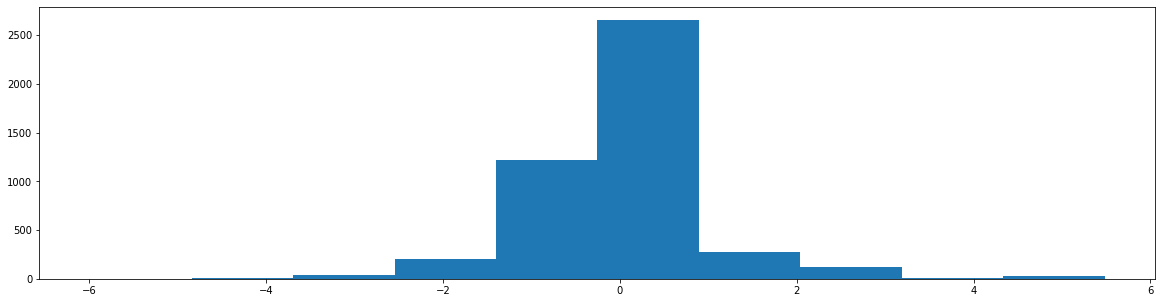

In [397]:
plt.hist(np.log(df.closest_wb_distance_m))

(array([   8.,   19.,   60.,  157.,  610., 1481., 2362., 1100.,  159.,
          18.]),
 array([-4.15792354, -3.52163264, -2.88534174, -2.24905083, -1.61275993,
        -0.97646902, -0.34017812,  0.29611278,  0.93240369,  1.56869459,
         2.20498549]),
 <BarContainer object of 10 artists>)

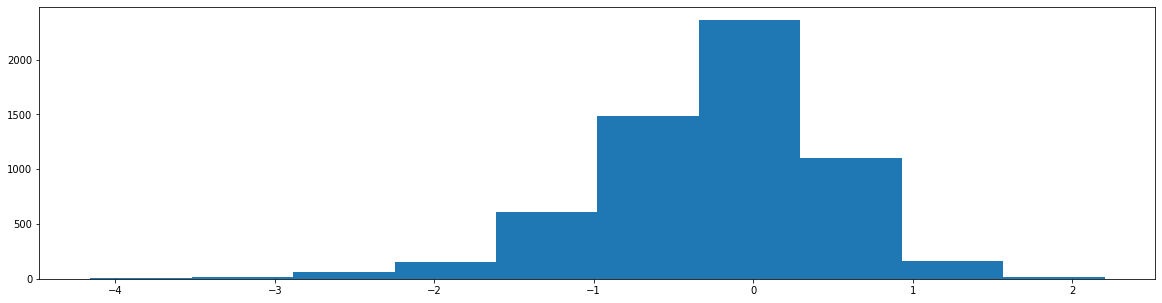

In [396]:
plt.hist(np.log(df.closest_fl_distance_m))

(array([  11.,   18.,   46.,   94.,  267.,  968., 2179., 1245.,  240.,
          17.]),
 array([-7.01311579, -5.75128829, -4.48946079, -3.22763329, -1.96580579,
        -0.70397829,  0.55784921,  1.81967671,  3.08150421,  4.34333171,
         5.60515921]),
 <BarContainer object of 10 artists>)

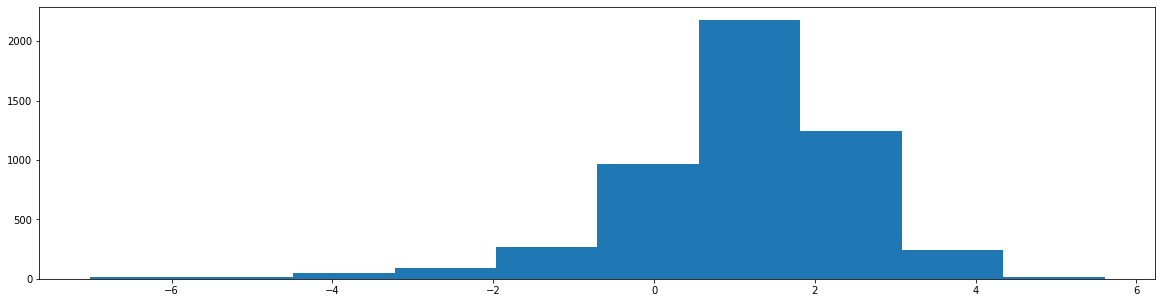

In [421]:
plt.hist(np.log(df.closest_fl_area_sqkm.apply(lambda x: x if x > 0 else np.nan)))

(array([4.160e+02, 1.315e+03, 5.170e+02, 2.770e+02, 1.390e+02, 8.400e+01,
        4.000e+01, 4.000e+01, 1.000e+00, 2.700e+01]),
 array([-5.80914299, -4.13224572, -2.45534845, -0.77845118,  0.89844608,
         2.57534335,  4.25224062,  5.92913789,  7.60603516,  9.28293243,
        10.9598297 ]),
 <BarContainer object of 10 artists>)

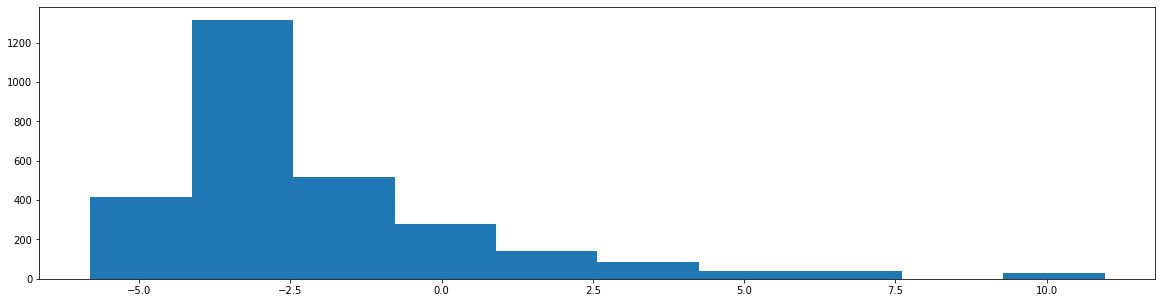

In [414]:
plt.hist(np.log(df.closest_wb_area_sqkm))

(array([   9.,   14.,   64.,  174.,  580.,  766., 1046., 2309.,  503.,
         268.]),
 array([-3.48124009, -2.31319714, -1.1451542 ,  0.02288875,  1.19093169,
         2.35897463,  3.52701758,  4.69506052,  5.86310347,  7.03114641,
         8.19918936]),
 <BarContainer object of 10 artists>)

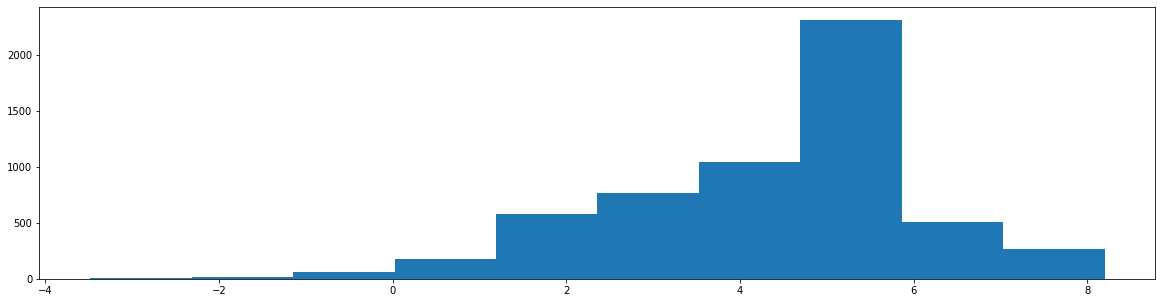

In [420]:
plt.hist(np.log(df.closest_fl_elevation.apply(lambda x: x if x > 0 else np.nan)))

# Light GBM

In [347]:
start = datetime.now()

In [348]:
# https://www.kaggle.com/binilg/lightgbm-with-randomsearchcv-and-feature-imp
# Implementation: https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761
# Documentation: https://lightgbm.readthedocs.io/en/latest/Features.html
# LightGBM Classifier: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#

import lightgbm
param_dict = {
    'learning_rate': [0.05],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['auc']
    }
#modelling
clf = lightgbm.LGBMClassifier()

if run_models:
    random_search_model = (RandomizedSearchCV(clf, 
                               param_dict, 
                               verbose=1, 
                               cv=10, 
                               n_jobs = -1, 
                               n_iter=10,
                               scoring='roc_auc'))
        # from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    random_search_model.fit(X, Y)
    model_dict["lgbm"] = random_search_model
    model_dict["file_params"] = file_param_dict
    pickle.dump(model_dict, open("random_search_fitted_models_" + FILE_VERSION, "wb"), protocol=3)

In [349]:
model_dict = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
lgbm = model_dict["lgbm"]
y_predict = lgbm.predict(test_X) 

# threshold is taken as 0.5, as proven here
# y_predict_ = 1 * (lr.predict_proba(test_X)[:, 1]>0.5) # 
# np.mean(y_predict == y_predict_)

In [350]:
model_results(lgbm, dev_X, dev_Y)

average_precision_score: 0.75571
roc_auc : 0.85153
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1848
           1       0.75      0.56      0.64      1017

    accuracy                           0.78      2865
   macro avg       0.77      0.73      0.74      2865
weighted avg       0.77      0.78      0.77      2865



Text(0, 0.5, 'Feature Importance Score')

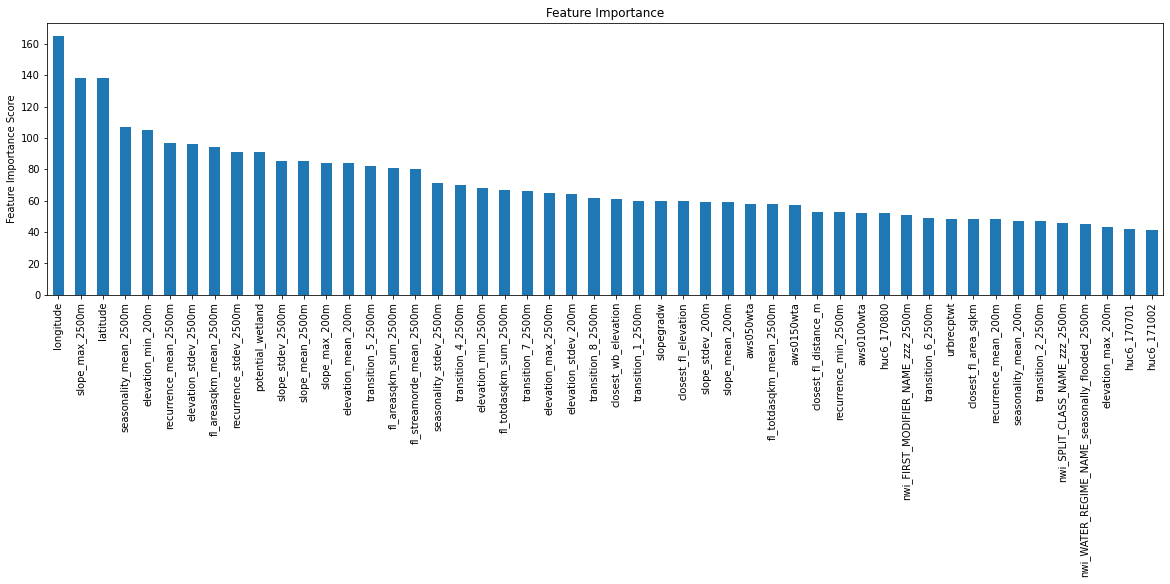

In [351]:
#Feature importance for top 50 predictors
predictors = [x for x in df_X_combined_dummies_ordered.columns]
feat_imp = pd.Series(lgbm.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

In [352]:
end = datetime.now()
time_taken(start, end)

Time taken (min): 0.0


In [353]:
# stop

# Logistic Regression

In [354]:
start = datetime.now()

In [355]:

# build a classifier
clf = LogisticRegression()

param_dict = {"C":np.logspace(-3,3,7), 
              "penalty":["l1", "l2", "elasticnet"],
              "l1_ratio":np.linspace(0,1,10),
              "solver":["lbfgs", "saga"]
              }# l1 lasso l2 ridge

# run randomized search
if run_logistic:
    random_search_model = RandomizedSearchCV(clf, 
                                       param_distributions=param_dict,
                                       n_iter=20, 
                                       scoring='roc_auc', 
                                       cv=10, 
                                       n_jobs=-1)


    # from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    random_search_model.fit(X, Y)
    model_dict["lr"] = random_search_model
    model_dict["file_params"] = file_param_dict
    pickle.dump(model_dict, open("random_search_fitted_models_" + FILE_VERSION, "wb"), protocol=3)


In [356]:
try:
    model_dict = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
    lr = model_dict["lr"]
    model_results(lr, dev_X, dev_Y)
except:
    pass

average_precision_score: 0.53897
roc_auc : 0.65288
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.93      0.79      1848
           1       0.66      0.24      0.35      1017

    accuracy                           0.69      2865
   macro avg       0.67      0.59      0.57      2865
weighted avg       0.68      0.69      0.64      2865



In [357]:
# not sure if useful
# precision, recall, thresholds = metrics.precision_recall_curve(test_Y, lr.predict_proba(test_X)[:, 1], pos_label=1)

# metrics.plot_precision_recall_curve(lr, test_X, test_Y, response_method='predict_proba')

In [358]:
end = datetime.now()
time_taken(start, end)

Time taken (min): 0.0


# XGBoost

In [359]:
start = datetime.now()

In [360]:
# build a classifier
clf = XGBRFClassifier()

# A parameter grid for XGBoost
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
param_dict = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

# run randomized search
if run_models:
    random_search_model = RandomizedSearchCV(clf, 
                                   param_distributions=param_dict,
                                   n_iter=1, 
                                   scoring='roc_auc', 
                                   cv=10, 
                                   n_jobs=-1)


    # from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    random_search_model.fit(X, Y)
    model_dict["xgb"] = random_search_model
    model_dict["file_params"] = file_param_dict    
    pickle.dump(model_dict, open("random_search_fitted_models_" + FILE_VERSION, "wb"), protocol=3)

In [361]:
model_dict = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
xgb = model_dict["xgb"]
y_predict = lr.predict(test_X) 

# threshold is taken as 0.5, as proven here
# y_predict_ = 1 * (lr.predict_proba(test_X)[:, 1]>0.5) # 
# np.mean(y_predict == y_predict_)

In [362]:
model_results(xgb, dev_X, dev_Y)

average_precision_score: 0.70239
roc_auc : 0.80634
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.82      1848
           1       0.73      0.47      0.57      1017

    accuracy                           0.75      2865
   macro avg       0.74      0.69      0.70      2865
weighted avg       0.75      0.75      0.74      2865



Text(0, 0.5, 'Feature Importance Score')

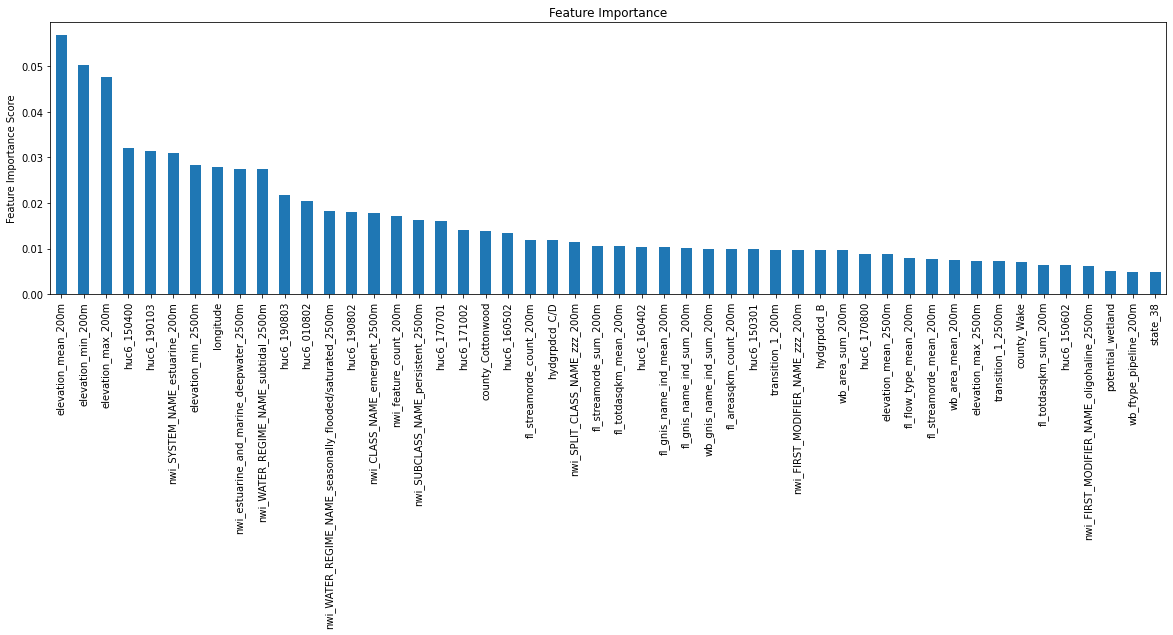

In [363]:
#Feature importance for top 50 predictors
predictors = [x for x in df_X_combined_dummies_ordered.columns]
feat_imp = pd.Series(xgb.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

In [364]:
end = datetime.now()
time_taken(start, end)

Time taken (min): 0.0


# Stacking

### http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/

In [365]:
start = datetime.now()

In [366]:
# classifiers, meta_classifier, use_probas=False, cv=2, 
# use_features_in_secondary=False, stratify=True, shuffle=True, verbose=0, store_train_meta_features=False, use_clones=True)

model_dict = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
xgb = model_dict["xgb"]
lgbm = model_dict["lgbm"]

if run_models:
    stack_gen_model = (StackingCVClassifier(classifiers=[xgb.best_estimator_,
                                                         lgbm.best_estimator_], 
                                            meta_classifier=xgb.best_estimator_,
                                            use_features_in_secondary=True,
                                            use_probas=True,
                                           random_state=random_state))

    stack_gen_model.fit(X, Y)
    model_dict["stacking"] = stack_gen_model
    model_dict["file_params"] = file_param_dict
    pickle.dump(model_dict, open("random_search_fitted_models_" + FILE_VERSION, "wb"), protocol=3)
    
model_dict = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
stacking = model_dict["stacking"]
y_predict = stacking.predict(test_X) 
y_score = stacking.predict_proba(test_X)

In [367]:
# Compute ROC curve and ROC area for each class
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()


fpr, tpr, _ = roc_curve(test_Y, y_score[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plt.figure()
# lw = 2
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

0.8513976686070625

In [368]:
model_results(stack_gen_model, test_X, test_Y)

average_precision_score: 0.78599
roc_auc : 0.8514
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1797
           1       0.77      0.56      0.65      1068

    accuracy                           0.78      2865
   macro avg       0.78      0.73      0.74      2865
weighted avg       0.78      0.78      0.77      2865



In [369]:
end = datetime.now()
time_taken(start, end)

Time taken (min): 0.0


# VotingClassifier

In [370]:
start = datetime.now()

In [371]:
if run_models:
    vc_clf = (VotingClassifier(estimators=[("xbg", model_dict["xgb"]), 
                                           ("lightgbm", model_dict["lgbm"]),
                                          ("stacking", model_dict["stacking"])],
                                           voting="soft",
                                           flatten_transform=False))

    vc_fit = vc_clf.fit(dev_X, dev_Y)
    model_dict["voting_clf"] = vc_fit
    model_dict["file_params"] = file_param_dict
    pickle.dump(model_dict, open("random_search_fitted_models_" + FILE_VERSION, "wb"), protocol=3)

model_dict = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
voting_clf = model_dict["voting_clf"]
y_predict = voting_clf.predict(test_X) 
y_score = voting_clf.predict_proba(test_X)

In [372]:
model_results(voting_clf, test_X, test_Y)
# find_roc_auc(vc_fit, test_X, test_Y)

average_precision_score: 0.7476
roc_auc : 0.82554
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1797
           1       0.76      0.49      0.60      1068

    accuracy                           0.75      2865
   macro avg       0.76      0.70      0.71      2865
weighted avg       0.76      0.75      0.74      2865



In [373]:
end = datetime.now()
time_taken(start, end)

Time taken (min): 0.0


# Model Comparison

In [374]:
model_dict.keys()

dict_keys(['lr', 'file_params', 'xgb', 'lgbm', 'stacking', 'voting_clf'])

In [375]:
def model_results(fitted_model, test_X, test_Y):
#     print("accuracy:", np.mean(test_Y == log_best_model.predict(test_X)))
#     print("balanced_accuracy_score:", balanced_accuracy_score(test_Y, log_best_model.predict(test_X)))

    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
    # AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold
    print("average_precision_score:", round(metrics.average_precision_score(test_Y, fitted_model.predict_proba(test_X)[:, 1], average="weighted"), 5))
    
    y_prob = fitted_model.predict_proba(test_X)
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, y_prob[:, 1], pos_label=1)
    print("roc_auc",":", round(metrics.auc(fpr, tpr), 5))
    
    print("Classification Report:") # threshold agnostic because you pass in the test labels instead of scores (probabilities)
    print(classification_report(test_Y, fitted_model.predict(test_X)))

In [376]:
print("ROC_AUC on Test")
print("===============")
for model in model_dict.keys():
    if model not in ["file_params"]:
        print("{}:{}{}".format(model, " "*(13 - len(model)), find_roc_auc(model_dict.get(model), test_X, test_Y)))

ROC_AUC on Test
lr:           0.64444
xgb:          0.80494
lgbm:         0.85336
stacking:     0.8514
voting_clf:   0.82554


In [377]:
print("ROC_AUC on Dev")
print("==============")
for model in model_dict.keys():
    if model not in ["file_params"]:
        print("{}:{}{}".format(model, " "*(13 - len(model)), find_roc_auc(model_dict.get(model), dev_X, dev_Y)))

ROC_AUC on Dev
lr:           0.65288
xgb:          0.80634
lgbm:         0.85153
stacking:     0.84552
voting_clf:   0.94333


In [378]:
print("ROC_AUC on Training")
print("===================")
for model in model_dict.keys():
    if model not in ["file_params"]:
        print("{}:{}{}".format(model, " "*(13 - len(model)), find_roc_auc(model_dict.get(model), X, Y)))

ROC_AUC on Training
lr:           0.67112
xgb:          0.8396
lgbm:         0.96776
stacking:     0.95677
voting_clf:   0.83665


# Residual Analysis

In [379]:
array1 = np.array(df_test)
model = "lgbm"
y_predict = model_dict[model].predict(test_X)
array2 = y_predict.reshape(y_predict.shape[0],1)
array3 = np.hstack((array1, array2))
df_pred = pd.DataFrame(array3, columns = list(df_test.columns) + ["predictions"])
df_pred.head()

,cwa5,cwa1,cwa8,cwa6,rha_determination,longitude,cwa7,potential_wetland,district,cwa3,...,state,closest_wb_distance_m,closest_fl_distance_m,closest_fl_area_sqkm,closest_wb_area_sqkm,closest_fl_elevation,closest_wb_elevation,huc4,huc6,predictions
0,0,0,0,0,0,-78.8078,0,1,Charleston,0,...,45,0.91862,0.4678,3.5406,NaN,15.7794,9.66418,0304,030402,0
1,0,0,0,0,0,-89.7844,0,0,New Orleans,0,...,22,1.58967,0.11442,0.1719,0.312,6.46154,0,0809,080902,1
2,0,0,0,0,0,-92.2654,0,1,Kansas City,0,...,29,1.01855,0.81278,5.1417,0.029,266.821,264.938,1030,103001,0
3,0,0,0,0,0,-81.6541,0,1,Huntington,0,...,39,NaN,1.38248,10.8297,NaN,368.585,NaN,0504,050400,0
4,0,0,0,0,0,-81.5473,0,1,Jacksonville,0,...,12,1.30922,NaN,NaN,NaN,NaN,40.125,0308,030801,1


In [380]:
# false negatives

df_fn = df_pred[(df_pred.predictions == 0) & (df_pred.cwa_determination == 1)]
df_fn.head()

,cwa5,cwa1,cwa8,cwa6,rha_determination,longitude,cwa7,potential_wetland,district,cwa3,...,state,closest_wb_distance_m,closest_fl_distance_m,closest_fl_area_sqkm,closest_wb_area_sqkm,closest_fl_elevation,closest_wb_elevation,huc4,huc6,predictions
9,1,0,1,0,0,-81.6144,0,1,Charleston,1,...,45,NaN,1.44789,24.0696,NaN,148.373,NaN,0305,030501,0
14,1,0,1,1,0,-78.9143,0,1,Wilmington,0,...,37,0.41337,NaN,NaN,NaN,NaN,159.7,0301,030101,0
20,1,0,0,0,0,-78.9201,0,1,Wilmington,1,...,37,NaN,1.0667,1.341,NaN,97,NaN,0303,030300,0
37,0,0,0,0,0,-79.2859,0,0,Charleston,0,...,45,2.0484,0.78012,1.1043,NaN,5.3037,10.3433,0304,030402,0
41,1,0,0,0,0,-80.123,0,0,Charleston,0,...,45,1.30391,1.08369,9.7281,NaN,34.4662,23.1642,0305,030502,0


In [381]:
imp_cols = ['cwa1', 'cwa2', 'cwa3', 'cwa4', 'cwa5', 'cwa6' , 'cwa7', 'cwa8', 'cwa9', 'cwa_determination','longitude', 'latitude', 'Index','da_number',
       'jurisdiction_type', 'potential_wetland', "predictions"]
df_fn[imp_cols]

,cwa1,cwa2,cwa3,cwa4,cwa5,cwa6,cwa7,cwa8,cwa9,cwa_determination,longitude,latitude,Index,da_number,jurisdiction_type,potential_wetland,predictions
9,0,0,1,0,1,0,0,1,0,1,-81.6144,34.2756,8388,SAC-2015-01137,RAPANOS,1,0
14,0,0,0,0,1,1,0,1,0,1,-78.9143,36.4781,11552,SAW-2016-01602,RAPANOS,1,0
20,0,0,1,0,1,0,0,0,0,1,-78.9201,35.7799,11616,SAW-2016-02305,RAPANOS,1,0
37,0,1,0,0,0,0,0,0,0,1,-79.2859,33.4078,8518,SAC-2016-00219-3JY,RAPANOS,0,0
41,0,0,0,0,1,0,0,0,0,1,-80.123,33.0515,8680,SAC-2016-01169,RAPANOS,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,0,0,0,0,1,0,0,0,0,1,-79.8506,32.8038,8582,SAC-2016-00619,RAPANOS,1,0
2848,0,0,0,0,1,0,0,0,0,1,-85.7867,38.6726,1419,LRL-2016-00601-MKD,RAPANOS,1,0
2853,0,0,0,0,1,0,0,0,0,1,-85.6818,41.3747,931,LRE-2017-00523-143,RAPANOS,0,0
2854,0,0,1,0,0,0,0,0,1,1,-91.0043,30.2581,3291,MVN-2015-01734-SQ,RAPANOS,1,0


In [382]:
model = "lgbm"
model_results(model_dict[model], test_X, test_Y)
confusion_matrix(test_Y, model_dict[model].predict(test_X))

average_precision_score: 0.78912
roc_auc : 0.85336
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1797
           1       0.75      0.58      0.66      1068

    accuracy                           0.77      2865
   macro avg       0.77      0.74      0.74      2865
weighted avg       0.77      0.77      0.77      2865



array([[1594,  203],
       [ 445,  623]])

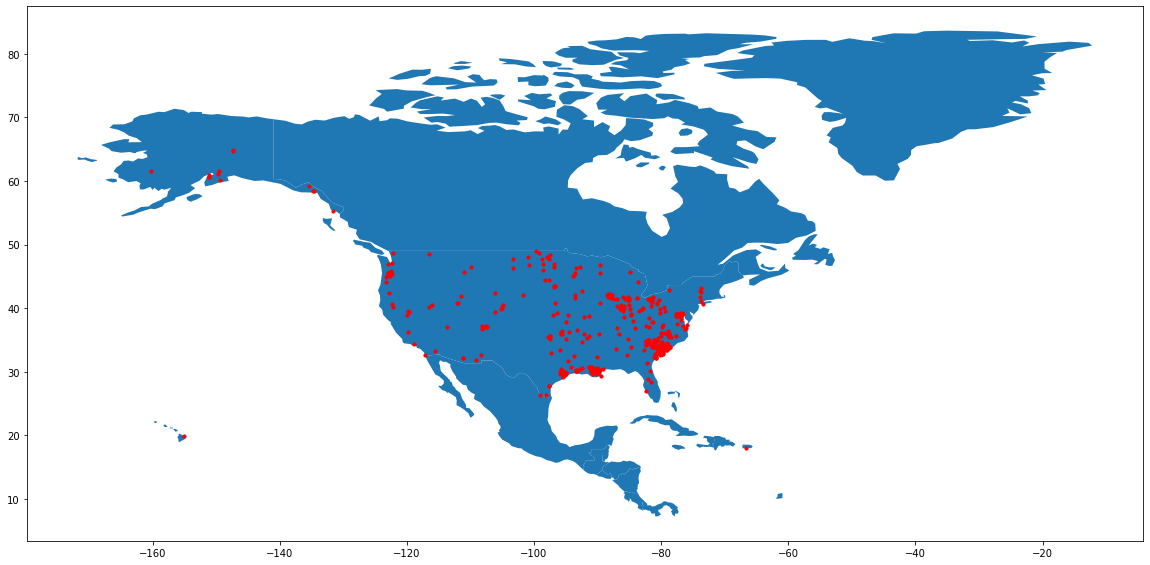

In [383]:
# false negatives

geometry = [Point(xy) for xy in zip(df_fn['longitude'], df_fn['latitude'])]
gdf = GeoDataFrame(df_fn, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == "North America"]
gdf.plot(ax=north_america.plot(figsize=(20, 12)), marker='o', color='red', markersize=10);

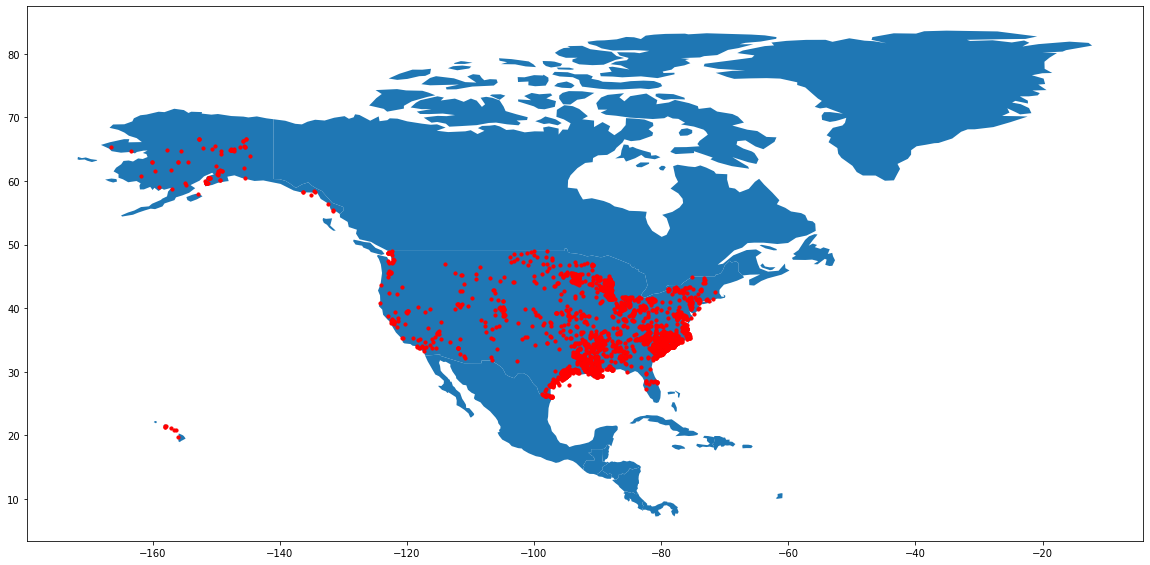

In [384]:
# not false negatives
df_not_fn = df_pred[~((df_pred.predictions == 0) & (df_pred.cwa_determination == 1))]

geometry = [Point(xy) for xy in zip(df_not_fn['longitude'], df_not_fn['latitude'])]
gdf = GeoDataFrame(df_not_fn, geometry=geometry)   

gdf.plot(ax=north_america.plot(figsize=(20, 12)), marker='o', color='red', markersize=10);

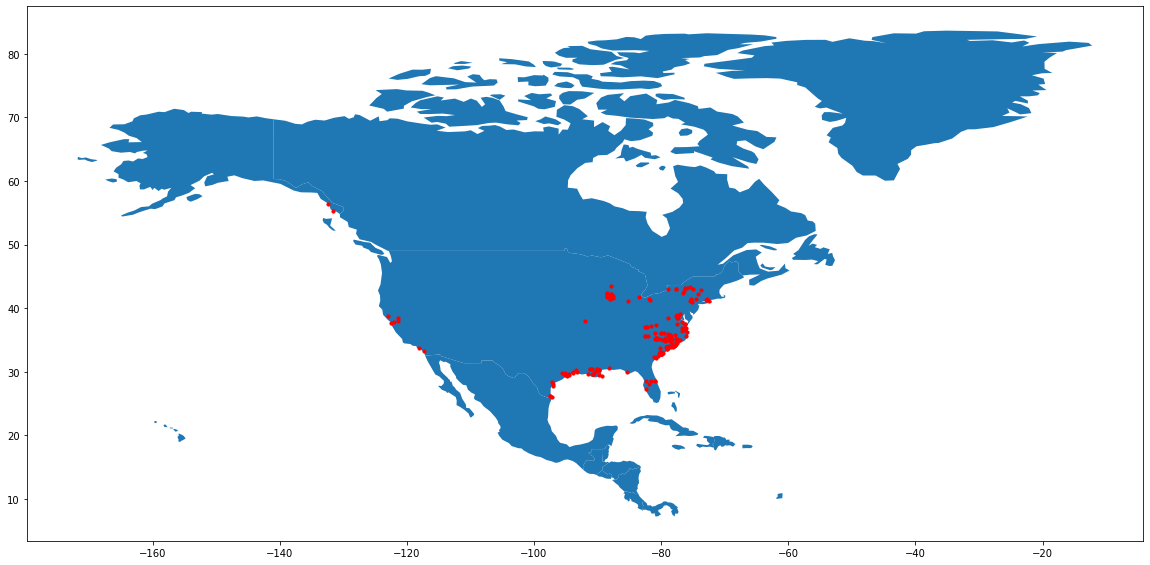

In [385]:
# false positives
df_fp = df_pred[(df_pred.predictions == 1) & (df_pred.cwa_determination == 0)]

geometry = [Point(xy) for xy in zip(df_fp['longitude'], df_fp['latitude'])]
gdf = GeoDataFrame(df_fp, geometry=geometry)   

gdf.plot(ax=north_america.plot(figsize=(20, 12)), marker='o', color='red', markersize=10);

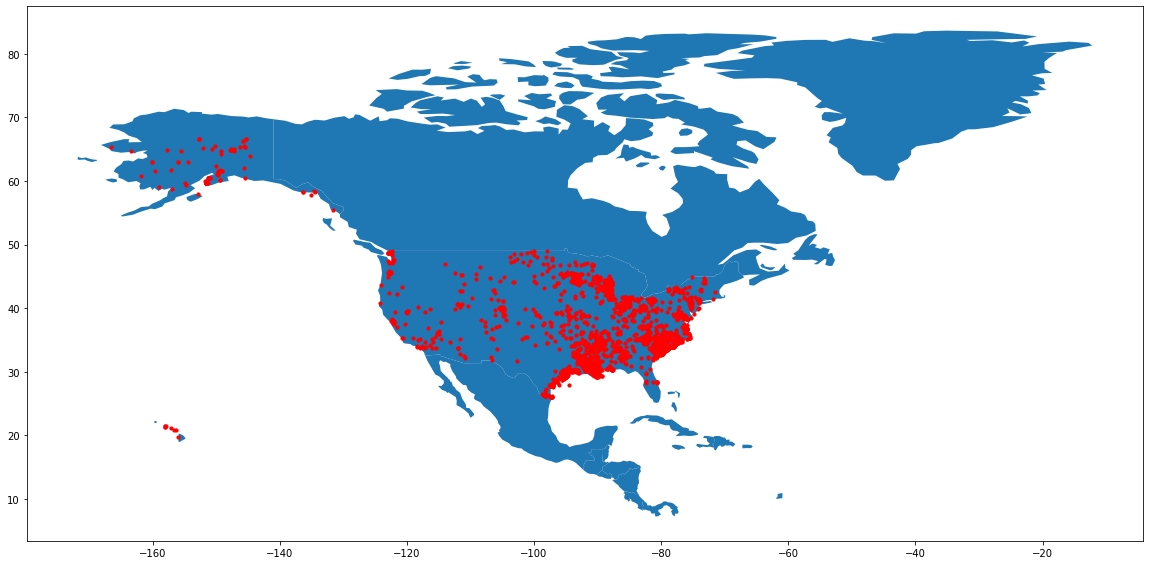

In [386]:
# All good predictions
df_good_preds = df_pred[((df_pred.predictions == 0) & (df_pred.cwa_determination == 0)) | ((df_pred.predictions == 1) & (df_pred.cwa_determination == 1))]

geometry = [Point(xy) for xy in zip(df_good_preds['longitude'], df_good_preds['latitude'])]
gdf = GeoDataFrame(df_good_preds, geometry=geometry)   

gdf.plot(ax=north_america.plot(figsize=(20, 12)), marker='o', color='red', markersize=10);

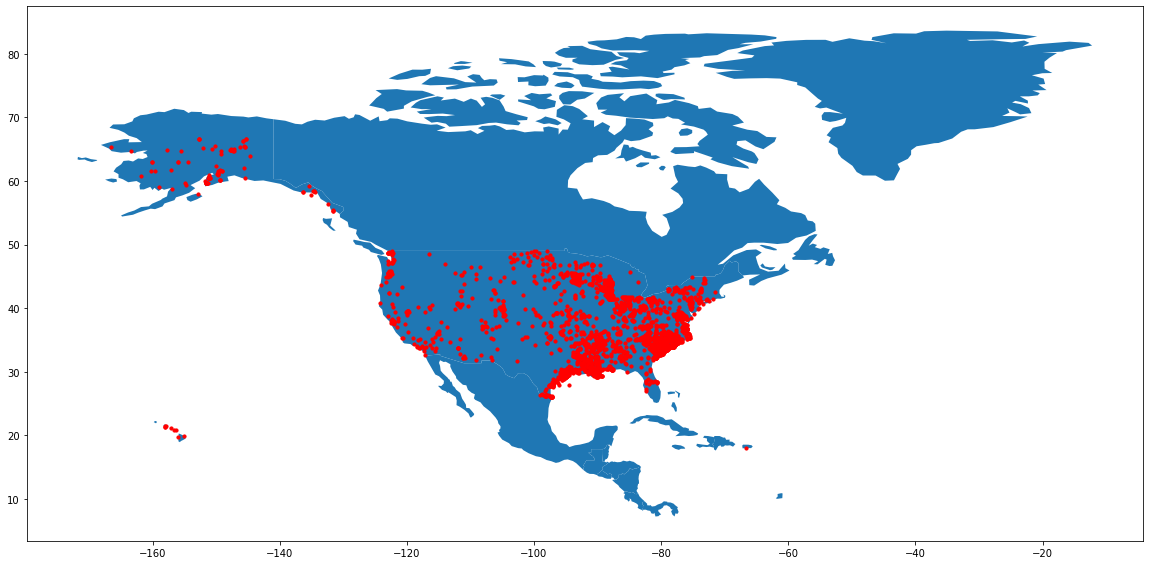

In [387]:
# All data

geometry = [Point(xy) for xy in zip(df_pred['longitude'], df_pred['latitude'])]
gdf = GeoDataFrame(df_pred, geometry=geometry)   

gdf.plot(ax=north_america.plot(figsize=(20, 12)), marker='o', color='red', markersize=10);

# Break


In [388]:
df_fn[df_fn.state == '12']["hydclprs"]#['da_number']

173      0
561     85
1471     4
1863     0
Name: hydclprs, dtype: object

In [389]:
set(df_fn.columns)

{'Index',
 'awmmfpwwta',
 'aws0100wta',
 'aws0150wta',
 'aws025wta',
 'aws050wta',
 'brockdepmi',
 'closest_fl_area_sqkm',
 'closest_fl_distance_m',
 'closest_fl_elevation',
 'closest_wb_area_sqkm',
 'closest_wb_distance_m',
 'closest_wb_elevation',
 'county',
 'cwa1',
 'cwa2',
 'cwa3',
 'cwa4',
 'cwa5',
 'cwa6',
 'cwa7',
 'cwa8',
 'cwa9',
 'cwa_determination',
 'da_number',
 'date_issued_or_denied',
 'district',
 'drclassdcd',
 'drclasswet',
 'elevation_max_200m',
 'elevation_max_2500m',
 'elevation_mean_200m',
 'elevation_mean_2500m',
 'elevation_min_200m',
 'elevation_min_2500m',
 'elevation_stdev_200m',
 'elevation_stdev_2500m',
 'engcmssdcd',
 'engcmssmp',
 'engdwbdcd',
 'engdwbll',
 'engdwbml',
 'engdwobdcd',
 'englrsdcd',
 'engsldcd',
 'engsldcp',
 'engstafdcd',
 'engstafll',
 'engstafml',
 'fl_areasqkm_count_200m',
 'fl_areasqkm_count_2500m',
 'fl_areasqkm_mean_200m',
 'fl_areasqkm_mean_2500m',
 'fl_areasqkm_sum_200m',
 'fl_areasqkm_sum_2500m',
 'fl_divergence_count_200m',
 'fl

In [391]:
model_dict["file_params"].keys()

dict_keys(['random_state', 'dev', 'imp_num_feature', 'imp_cat_feature'])